In [0]:
# Importing necessary libraries for handling the data with PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd

# Setting up the Spark session
spark = SparkSession.builder\
                    .appName("StormEventsAnalysis")\
                    .getOrCreate()

In [0]:
storm_data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/StormEvents_details_ftp_v1_0_d2023_c20240317.csv", inferSchema=True)
# Show the first few rows and print the schema to understand the dataset
storm_data.show(5)


+---------------+---------+----------+-------------+-------+--------+----------+--------+------------+----------+----+----------+----------+-------+-------+-----------+---+------------------+-----------+------------------+---------------+-----------------+-------------+---------------+---------------+------------+-----------------+---------+--------------+-----------+--------+-----------+----------+---------+-------------+------------------+-----------------+-----------------+-----------+-------------+--------------+---------+-----------+------------+---------+---------+-------+-------+--------------------+--------------------+-----------+
|BEGIN_YEARMONTH|BEGIN_DAY|BEGIN_TIME|END_YEARMONTH|END_DAY|END_TIME|EPISODE_ID|EVENT_ID|       STATE|STATE_FIPS|YEAR|MONTH_NAME|EVENT_TYPE|CZ_TYPE|CZ_FIPS|    CZ_NAME|WFO|   BEGIN_DATE_TIME|CZ_TIMEZONE|     END_DATE_TIME|INJURIES_DIRECT|INJURIES_INDIRECT|DEATHS_DIRECT|DEATHS_INDIRECT|DAMAGE_PROPERTY|DAMAGE_CROPS|           SOURCE|MAGNITUDE|MAGNITUDE

In [0]:
storm_data.head()

Row(BEGIN_YEARMONTH=202310, BEGIN_DAY=25, BEGIN_TIME=230, END_YEARMONTH=202310, END_DAY=27, END_TIME=551, EPISODE_ID=186682, EVENT_ID=1145781, STATE='NORTH DAKOTA', STATE_FIPS=38, YEAR=2023, MONTH_NAME='October', EVENT_TYPE='Heavy Snow', CZ_TYPE='Z', CZ_FIPS=14, CZ_NAME='BENSON', WFO='FGF', BEGIN_DATE_TIME='25-OCT-23 02:30:00', CZ_TIMEZONE='CST-6', END_DATE_TIME='27-OCT-23 05:51:00', INJURIES_DIRECT=0, INJURIES_INDIRECT=0, DEATHS_DIRECT=0, DEATHS_INDIRECT=0, DAMAGE_PROPERTY=None, DAMAGE_CROPS=None, SOURCE='Public', MAGNITUDE=None, MAGNITUDE_TYPE=None, FLOOD_CAUSE=None, CATEGORY=None, TOR_F_SCALE=None, TOR_LENGTH=None, TOR_WIDTH=None, TOR_OTHER_WFO=None, TOR_OTHER_CZ_STATE=None, TOR_OTHER_CZ_FIPS=None, TOR_OTHER_CZ_NAME=None, BEGIN_RANGE=None, BEGIN_AZIMUTH=None, BEGIN_LOCATION=None, END_RANGE=None, END_AZIMUTH=None, END_LOCATION=None, BEGIN_LAT=None, BEGIN_LON=None, END_LAT=None, END_LON=None, EPISODE_NARRATIVE='In late October, a winter storm dumped heavy snow in eastern North Dakota 

In [0]:
# Display the schema to understand the structure and types of data we're dealing with
storm_data.printSchema()


root
 |-- BEGIN_YEARMONTH: integer (nullable = true)
 |-- BEGIN_DAY: integer (nullable = true)
 |-- BEGIN_TIME: integer (nullable = true)
 |-- END_YEARMONTH: integer (nullable = true)
 |-- END_DAY: integer (nullable = true)
 |-- END_TIME: integer (nullable = true)
 |-- EPISODE_ID: integer (nullable = true)
 |-- EVENT_ID: integer (nullable = true)
 |-- STATE: string (nullable = true)
 |-- STATE_FIPS: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH_NAME: string (nullable = true)
 |-- EVENT_TYPE: string (nullable = true)
 |-- CZ_TYPE: string (nullable = true)
 |-- CZ_FIPS: integer (nullable = true)
 |-- CZ_NAME: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- BEGIN_DATE_TIME: string (nullable = true)
 |-- CZ_TIMEZONE: string (nullable = true)
 |-- END_DATE_TIME: string (nullable = true)
 |-- INJURIES_DIRECT: integer (nullable = true)
 |-- INJURIES_INDIRECT: integer (nullable = true)
 |-- DEATHS_DIRECT: integer (nullable = true)
 |-- DEATHS_INDIRE

In [0]:
# Data Cleaning: Checking for missing values
missing_data_counts = storm_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in storm_data.columns])
missing_data_counts.show()

+---------------+---------+----------+-------------+-------+--------+----------+--------+-----+----------+----+----------+----------+-------+-------+-------+---+---------------+-----------+-------------+---------------+-----------------+-------------+---------------+---------------+------------+------+---------+--------------+-----------+--------+-----------+----------+---------+-------------+------------------+-----------------+-----------------+-----------+-------------+--------------+---------+-----------+------------+---------+---------+-------+-------+-----------------+---------------+-----------+
|BEGIN_YEARMONTH|BEGIN_DAY|BEGIN_TIME|END_YEARMONTH|END_DAY|END_TIME|EPISODE_ID|EVENT_ID|STATE|STATE_FIPS|YEAR|MONTH_NAME|EVENT_TYPE|CZ_TYPE|CZ_FIPS|CZ_NAME|WFO|BEGIN_DATE_TIME|CZ_TIMEZONE|END_DATE_TIME|INJURIES_DIRECT|INJURIES_INDIRECT|DEATHS_DIRECT|DEATHS_INDIRECT|DAMAGE_PROPERTY|DAMAGE_CROPS|SOURCE|MAGNITUDE|MAGNITUDE_TYPE|FLOOD_CAUSE|CATEGORY|TOR_F_SCALE|TOR_LENGTH|TOR_WIDTH|TOR_OTHE

In [0]:
# Extract year and month from BEGIN_YEARMONTH and END_YEARMONTH
storm_data = storm_data.withColumn("BEGIN_YEAR", col("BEGIN_YEARMONTH").substr(1, 4).cast("int"))
storm_data = storm_data.withColumn("BEGIN_MONTH", col("BEGIN_YEARMONTH").substr(5, 2).cast("int"))
storm_data = storm_data.withColumn("END_YEAR", col("END_YEARMONTH").substr(1, 4).cast("int"))
storm_data = storm_data.withColumn("END_MONTH", col("END_YEARMONTH").substr(5, 2).cast("int"))

# Show the DataFrame with the new columns to verify the changes
storm_data.select("BEGIN_YEARMONTH", "BEGIN_MONTH", "END_YEARMONTH", "END_MONTH").show()

+---------------+-----------+-------------+---------+
|BEGIN_YEARMONTH|BEGIN_MONTH|END_YEARMONTH|END_MONTH|
+---------------+-----------+-------------+---------+
|         202310|         10|       202310|       10|
|         202310|         10|       202310|       10|
|         202310|         10|       202310|       10|
|         202310|         10|       202310|       10|
|         202310|         10|       202310|       10|
|         202310|         10|       202310|       10|
|         202303|          3|       202303|        3|
|         202310|         10|       202310|       10|
|         202310|         10|       202310|       10|
|         202308|          8|       202308|        8|
|         202308|          8|       202308|        8|
|         202309|          9|       202309|        9|
|         202309|          9|       202309|        9|
|         202308|          8|       202308|        8|
|         202310|         10|       202310|       10|
|         202309|          9

In [0]:
# Count the total number of columns
total_columns = len(storm_data.columns)

# Print the total number of columns
print(total_columns)

55


In [0]:
# Drop the 'BEGIN_YEARMONTH', 'END_YEARMONTH', and year columns
storm_data = storm_data.drop("BEGIN_YEARMONTH", "END_YEARMONTH", "BEGIN_YEAR", "END_YEAR", "YEAR")

In [0]:
# Count the total number of columns
total_columns = len(storm_data.columns)
print(total_columns)

50


In [0]:
# Show the DataFrame with the new columns to verify the changes
storm_data.select("BEGIN_MONTH", "END_MONTH").show()


+-----------+---------+
|BEGIN_MONTH|END_MONTH|
+-----------+---------+
|         10|       10|
|         10|       10|
|         10|       10|
|         10|       10|
|         10|       10|
|         10|       10|
|          3|        3|
|         10|       10|
|         10|       10|
|          8|        8|
|          8|        8|
|          9|        9|
|          9|        9|
|          8|        8|
|         10|       10|
|          9|        9|
|         10|       10|
|         10|       10|
|         10|       10|
|          8|        8|
+-----------+---------+
only showing top 20 rows



In [0]:
# Count rows where 'BEGIN_MONTH' and 'END_MONTH' are not the same to merge the common columns later
mismatched_months_count = storm_data.filter(storm_data["BEGIN_MONTH"] != storm_data["END_MONTH"]).count()

# Print the result
print("Number of rows with different BEGIN_MONTH and END_MONTH:", mismatched_months_count)

Number of rows with different BEGIN_MONTH and END_MONTH: 0


In [0]:
# Create a new 'MONTH' column based on 'BEGIN_MONTH' (since BEGIN_MONTH and END_MONTH are the same)
storm_data = storm_data.withColumn("MONTH", col("BEGIN_MONTH"))
# Drop the 'BEGIN_MONTH' and 'END_MONTH' columns
storm_data = storm_data.drop("BEGIN_MONTH", "END_MONTH")


In [0]:
# Count the total number of columns
total_columns = len(storm_data.columns)
# Print the total number of columns
print(total_columns)
# Show the DataFrame with the new columns to verify the changes
storm_data.select("MONTH").show()

49
+-----+
|MONTH|
+-----+
|   10|
|   10|
|   10|
|   10|
|   10|
|   10|
|    3|
|   10|
|   10|
|    8|
|    8|
|    9|
|    9|
|    8|
|   10|
|    9|
|   10|
|   10|
|   10|
|    8|
+-----+
only showing top 20 rows



In [0]:
list(storm_data.columns)

['BEGIN_DAY',
 'BEGIN_TIME',
 'END_DAY',
 'END_TIME',
 'EPISODE_ID',
 'EVENT_ID',
 'STATE',
 'STATE_FIPS',
 'MONTH_NAME',
 'EVENT_TYPE',
 'CZ_TYPE',
 'CZ_FIPS',
 'CZ_NAME',
 'WFO',
 'BEGIN_DATE_TIME',
 'CZ_TIMEZONE',
 'END_DATE_TIME',
 'INJURIES_DIRECT',
 'INJURIES_INDIRECT',
 'DEATHS_DIRECT',
 'DEATHS_INDIRECT',
 'DAMAGE_PROPERTY',
 'DAMAGE_CROPS',
 'SOURCE',
 'MAGNITUDE',
 'MAGNITUDE_TYPE',
 'FLOOD_CAUSE',
 'CATEGORY',
 'TOR_F_SCALE',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'TOR_OTHER_WFO',
 'TOR_OTHER_CZ_STATE',
 'TOR_OTHER_CZ_FIPS',
 'TOR_OTHER_CZ_NAME',
 'BEGIN_RANGE',
 'BEGIN_AZIMUTH',
 'BEGIN_LOCATION',
 'END_RANGE',
 'END_AZIMUTH',
 'END_LOCATION',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON',
 'EPISODE_NARRATIVE',
 'EVENT_NARRATIVE',
 'DATA_SOURCE',
 'MONTH']

In [0]:
# Show the DataFrame with the new columns to verify the changes
storm_data.select("MONTH").show()

+-----+
|MONTH|
+-----+
|   10|
|   10|
|   10|
|   10|
|   10|
|   10|
|    3|
|   10|
|   10|
|    8|
|    8|
|    9|
|    9|
|    8|
|   10|
|    9|
|   10|
|   10|
|   10|
|    8|
+-----+
only showing top 20 rows



In [0]:
# Calculate the simple difference in days to calculate the duration for which each instance of events 
storm_data = storm_data.withColumn("DURATION_DAYS", col("END_DAY") - col("BEGIN_DAY"))

storm_data = storm_data.drop("END_DAY", "BEGIN_DAY")

# Show the DataFrame to verify the new 'DURATION_DAYS' column
storm_data.select("DURATION_DAYS").show()

+-------------+
|DURATION_DAYS|
+-------------+
|            2|
|            2|
|            2|
|            2|
|            2|
|            2|
|            0|
|           16|
|            2|
|            0|
|            0|
|            0|
|            0|
|            0|
|            1|
|            0|
|           30|
|            0|
|            0|
|            0|
+-------------+
only showing top 20 rows



In [0]:
storm_data.head()

Row(BEGIN_TIME=230, END_TIME=551, EPISODE_ID=186682, EVENT_ID=1145781, STATE='NORTH DAKOTA', STATE_FIPS=38, MONTH_NAME='October', EVENT_TYPE='Heavy Snow', CZ_TYPE='Z', CZ_FIPS=14, CZ_NAME='BENSON', WFO='FGF', BEGIN_DATE_TIME='25-OCT-23 02:30:00', CZ_TIMEZONE='CST-6', END_DATE_TIME='27-OCT-23 05:51:00', INJURIES_DIRECT=0, INJURIES_INDIRECT=0, DEATHS_DIRECT=0, DEATHS_INDIRECT=0, DAMAGE_PROPERTY=None, DAMAGE_CROPS=None, SOURCE='Public', MAGNITUDE=None, MAGNITUDE_TYPE=None, FLOOD_CAUSE=None, CATEGORY=None, TOR_F_SCALE=None, TOR_LENGTH=None, TOR_WIDTH=None, TOR_OTHER_WFO=None, TOR_OTHER_CZ_STATE=None, TOR_OTHER_CZ_FIPS=None, TOR_OTHER_CZ_NAME=None, BEGIN_RANGE=None, BEGIN_AZIMUTH=None, BEGIN_LOCATION=None, END_RANGE=None, END_AZIMUTH=None, END_LOCATION=None, BEGIN_LAT=None, BEGIN_LON=None, END_LAT=None, END_LON=None, EPISODE_NARRATIVE='In late October, a winter storm dumped heavy snow in eastern North Dakota and northwestern Minnesota over a period of 2 days. Due to mesoscale forces at play

In [0]:
# Assuming 'BEGIN_TIME' and 'END_TIME' are in hhmm format as integers
# Convert integer times to "HH:mm" format
storm_data = storm_data.withColumn("BEGIN_TIME", lpad(col("BEGIN_TIME").cast("string"), 4, '0'))
storm_data = storm_data.withColumn("END_TIME", lpad(col("END_TIME").cast("string"), 4, '0'))

# Applying substring functions to insert ':' between HH and mm
storm_data = storm_data.withColumn("BEGIN_TIME", expr("substring(BEGIN_TIME, 1, 2) || ':' || substring(BEGIN_TIME, 3, 2)"))
storm_data = storm_data.withColumn("END_TIME", expr("substring(END_TIME, 1, 2) || ':' || substring(END_TIME, 3, 2)"))

# Show the DataFrame to verify the new time formats in 'BEGIN_TIME' and 'END_TIME'
storm_data.select("BEGIN_TIME", "END_TIME").show()

+----------+--------+
|BEGIN_TIME|END_TIME|
+----------+--------+
|     02:30|   05:51|
|     02:30|   14:37|
|     02:30|   11:26|
|     02:30|   13:01|
|     02:30|   06:00|
|     02:30|   08:00|
|     17:11|   17:11|
|     00:00|   00:00|
|     02:30|   10:51|
|     18:30|   18:35|
|     19:00|   19:05|
|     14:24|   14:24|
|     14:00|   14:00|
|     18:30|   18:35|
|     10:09|   04:20|
|     12:41|   12:41|
|     00:00|   23:59|
|     08:59|   09:00|
|     09:36|   09:37|
|     17:15|   17:20|
+----------+--------+
only showing top 20 rows



In [0]:
# Assume 'BEGIN_TIME' and 'END_TIME' are in the format "HH:mm"
# Convert "HH:mm" to minutes since midnight to facilitate subtraction
storm_data = storm_data.withColumn("BEGIN_MINUTES",
                                   expr("substring(BEGIN_TIME, 1, 2) * 60 + substring(BEGIN_TIME, 4, 2)"))
storm_data = storm_data.withColumn("END_MINUTES",
                                   expr("substring(END_TIME, 1, 2) * 60 + substring(END_TIME, 4, 2)"))

# Calculate the duration in minutes
# This will handle cases correctly assuming 'END_TIME' is always after 'BEGIN_TIME' within the same day
storm_data = storm_data.withColumn("TOTAL_MINUTES",
                                   col("END_MINUTES") - col("BEGIN_MINUTES"))

# Show the DataFrame to verify the new 'TOTAL_MINUTES' column
storm_data.select("BEGIN_TIME", "END_TIME", "TOTAL_MINUTES").show()


+----------+--------+-------------+
|BEGIN_TIME|END_TIME|TOTAL_MINUTES|
+----------+--------+-------------+
|     02:30|   05:51|        201.0|
|     02:30|   14:37|        727.0|
|     02:30|   11:26|        536.0|
|     02:30|   13:01|        631.0|
|     02:30|   06:00|        210.0|
|     02:30|   08:00|        330.0|
|     17:11|   17:11|          0.0|
|     00:00|   00:00|          0.0|
|     02:30|   10:51|        501.0|
|     18:30|   18:35|          5.0|
|     19:00|   19:05|          5.0|
|     14:24|   14:24|          0.0|
|     14:00|   14:00|          0.0|
|     18:30|   18:35|          5.0|
|     10:09|   04:20|       -349.0|
|     12:41|   12:41|          0.0|
|     00:00|   23:59|       1439.0|
|     08:59|   09:00|          1.0|
|     09:36|   09:37|          1.0|
|     17:15|   17:20|          5.0|
+----------+--------+-------------+
only showing top 20 rows



In [0]:
# Define a User defined function(UDF) for determining seasons based on the month
def season(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"

season_udf = spark.udf.register("season", season, StringType())

# Add additional columns for season
storm_data = storm_data.withColumn("SEASON", season_udf(col("MONTH")))

# Analysis 1: Count of storm events by type
event_counts=storm_data.groupBy("EVENT_TYPE").count().orderBy(col("count").desc())
event_counts.show()
# Filter to find event types where the total count is more than 3000
high_frequency_events = event_counts.filter(col("count") > 3000)

# Show the filtered event types with counts greater than 3000
high_frequency_events.show()

+--------------------+-----+
|          EVENT_TYPE|count|
+--------------------+-----+
|   Thunderstorm Wind|21121|
|                Hail|11685|
|             Drought| 5805|
|      Excessive Heat| 4736|
|         Flash Flood| 3618|
|           High Wind| 3487|
|                Heat| 3259|
|      Winter Weather| 2877|
|               Flood| 2834|
|Marine Thundersto...| 2609|
|          Heavy Snow| 2532|
|        Winter Storm| 2348|
|             Tornado| 1491|
|         Strong Wind| 1098|
|          Heavy Rain|  872|
|        Frost/Freeze|  533|
|           Dense Fog|  443|
|            Blizzard|  432|
|Extreme Cold/Wind...|  408|
|            Wildfire|  296|
+--------------------+-----+
only showing top 20 rows

+-----------------+-----+
|       EVENT_TYPE|count|
+-----------------+-----+
|Thunderstorm Wind|21121|
|             Hail|11685|
|          Drought| 5805|
|   Excessive Heat| 4736|
|      Flash Flood| 3618|
|        High Wind| 3487|
|             Heat| 3259|
+-----------------

In [0]:
# Filter to find event types where the total count is more than 3000
high_frequency_events = event_counts.filter(col("count") > 3000)

# Show the filtered event types with counts greater than 3000
high_frequency_events.show()

+-----------------+-----+
|       EVENT_TYPE|count|
+-----------------+-----+
|Thunderstorm Wind|21121|
|             Hail|11685|
|          Drought| 5805|
|   Excessive Heat| 4736|
|      Flash Flood| 3618|
|        High Wind| 3487|
|             Heat| 3259|
+-----------------+-----+



In [0]:
# Join the original dataset with the high frequency events to filter the data
filtered_data = storm_data.join(high_frequency_events, 'EVENT_TYPE')

# Count the number of rows in the DataFrame
row_count = filtered_data.count()

# Print the result
print("Total number of rows in the DataFrame:", row_count)

Total number of rows in the DataFrame: 53711


In [0]:
# Assuming 'high_frequency_events' is a DataFrame containing only the EVENT_TYPE of high frequency events
# and 'storm_data' is the main dataset which includes a 'DURATION_DAYS' column
# First, join the datasets to filter only high frequency events
filtered_data = storm_data.join(high_frequency_events, 'EVENT_TYPE')

# Now aggregate to sum 'DURATION_DAYS' for each high-frequency event type
total_days_by_event = filtered_data.groupBy("EVENT_TYPE")\
                                    .agg(sum("DURATION_DAYS").alias("TOTAL_DAYS"))\
                                    .orderBy(col("TOTAL_DAYS").desc())

# Show the results
total_days_by_event.show()

+-----------------+----------+
|       EVENT_TYPE|TOTAL_DAYS|
+-----------------+----------+
|          Drought|    142829|
|   Excessive Heat|      8525|
|             Heat|      5455|
|        High Wind|       381|
|      Flash Flood|       349|
|Thunderstorm Wind|        15|
|             Hail|        12|
+-----------------+----------+



+--------------------+-----+
|          EVENT_TYPE|count|
+--------------------+-----+
|   Thunderstorm Wind|21121|
|                Hail|11685|
|             Drought| 5805|
|      Excessive Heat| 4736|
|         Flash Flood| 3618|
|           High Wind| 3487|
|                Heat| 3259|
|      Winter Weather| 2877|
|               Flood| 2834|
|Marine Thundersto...| 2609|
|          Heavy Snow| 2532|
|        Winter Storm| 2348|
|             Tornado| 1491|
|         Strong Wind| 1098|
|          Heavy Rain|  872|
|        Frost/Freeze|  533|
|           Dense Fog|  443|
|            Blizzard|  432|
|Extreme Cold/Wind...|  408|
|            Wildfire|  296|
+--------------------+-----+
only showing top 20 rows



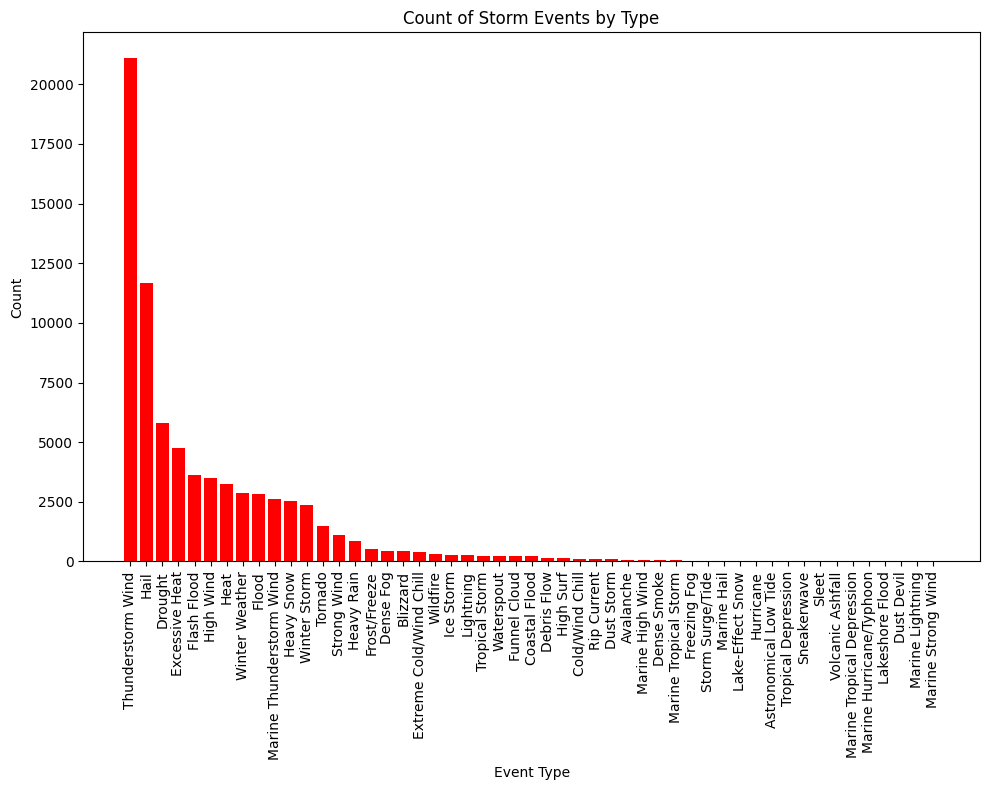

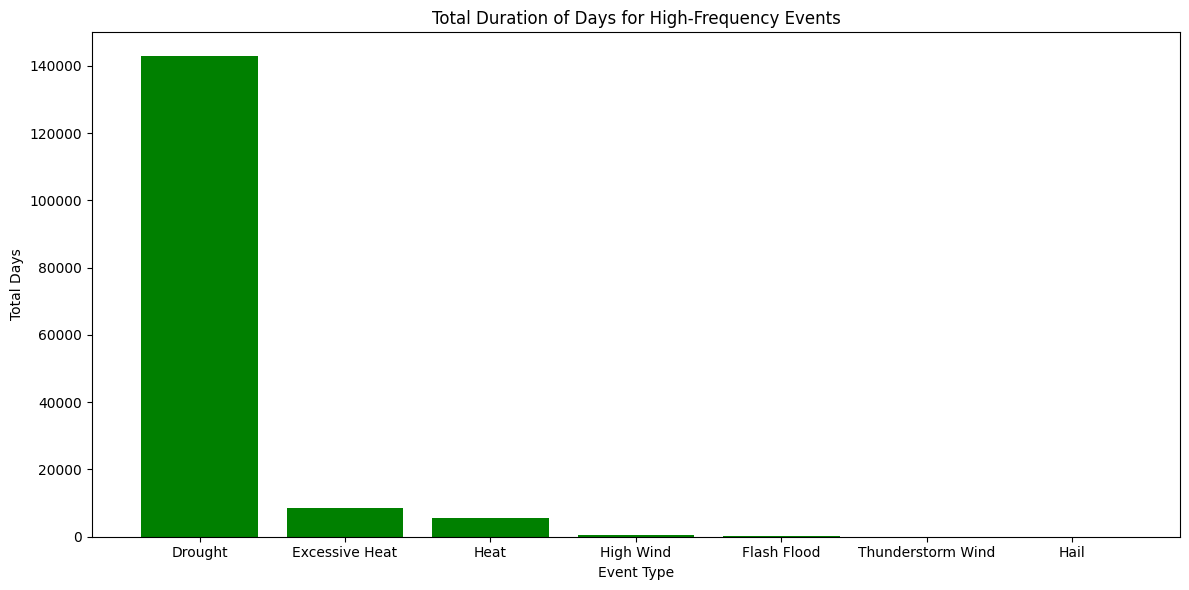

In [0]:
# Collect the data to the driver (use with caution if the data set is very large)
event_counts=storm_data.groupBy("EVENT_TYPE").count().orderBy(col("count").desc())
event_counts.show()
event_counts_data = event_counts.collect()

# Creating lists for plotting
event_types = [row['EVENT_TYPE'] for row in event_counts_data]
counts = [row['count'] for row in event_counts_data]

# Plotting the distribution of event types
plt.figure(figsize=(10, 8))
plt.bar(event_types, counts, color='red')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Count of Storm Events by Type')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.tight_layout()
plt.show()

total_days_data = total_days_by_event.collect()

# Visualize the total duration in days for high-frequency events
event_types_days = [row['EVENT_TYPE'] for row in total_days_data]
total_days = [row['TOTAL_DAYS'] for row in total_days_data]

plt.figure(figsize=(12, 6))
plt.bar(event_types_days, total_days, color='green')
plt.xlabel('Event Type')
plt.ylabel('Total Days')
plt.title('Total Duration of Days for High-Frequency Events')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

+-----------------+-----+
|       EVENT_TYPE|count|
+-----------------+-----+
|Thunderstorm Wind|21121|
|             Hail|11685|
|          Drought| 5805|
|   Excessive Heat| 4736|
|      Flash Flood| 3618|
|        High Wind| 3487|
|             Heat| 3259|
+-----------------+-----+



/root/.ipykernel/1161/command-2113572243730954-4148454921:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(states, rotation=90)


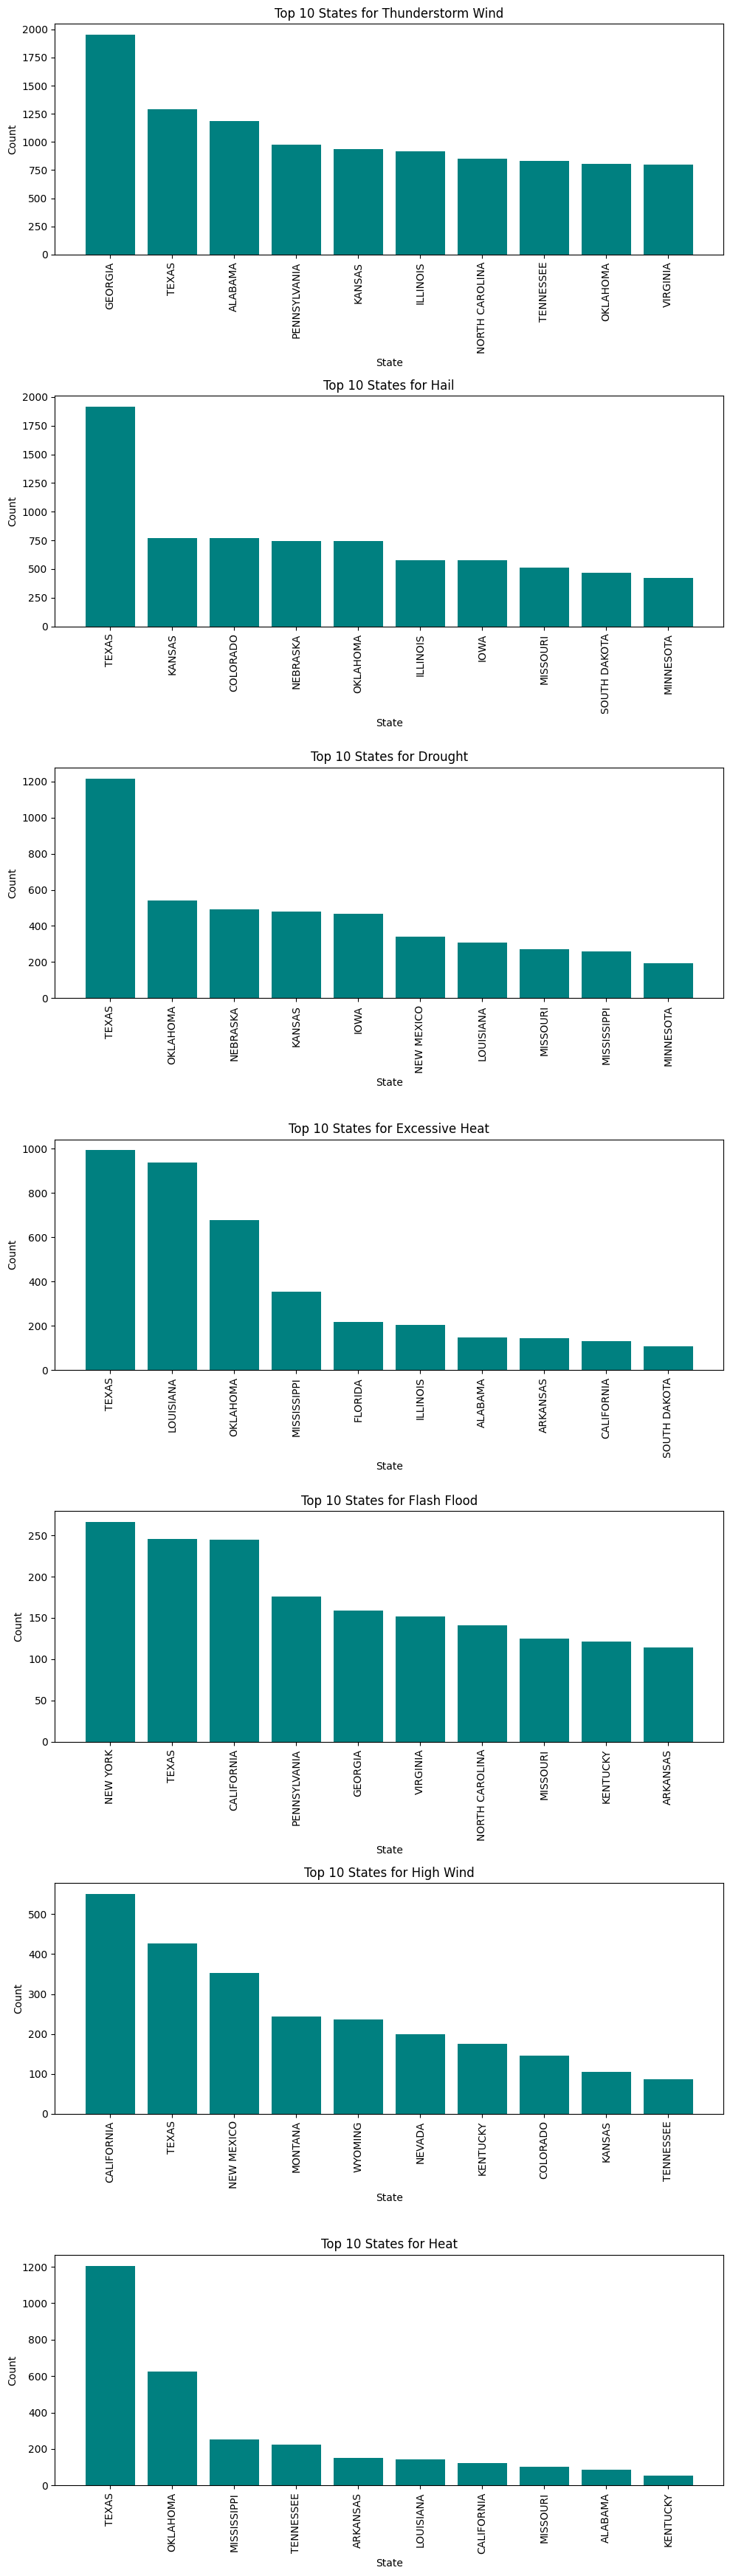

In [0]:
# Filter to find event types where the total count is more than 3000
high_frequency_events = event_counts.filter(col("count") > 3000)

# Show the filtered event types with counts greater than 3000
high_frequency_events.show()

## Join the high frequency events with the original dataset to filter the relevant records
filtered_data = storm_data.join(high_frequency_events, "EVENT_TYPE")

# Group by 'EVENT_TYPE' and 'STATE' to count occurrences, and order by count descending
state_event_counts = filtered_data.groupBy("EVENT_TYPE", "STATE").count().orderBy("EVENT_TYPE", col("count").desc())

# Collect data for plotting
state_event_counts_list = state_event_counts.collect()

# Prepare plotting data
event_types = high_frequency_events.select("EVENT_TYPE").rdd.flatMap(lambda x: x).collect()
event_type_to_state_counts = {event_type: [] for event_type in event_types}
for row in state_event_counts_list:
    event_type_to_state_counts[row['EVENT_TYPE']].append((row['STATE'], row['count']))

# Plotting
fig, axes = plt.subplots(nrows=len(event_types), figsize=(10, 5 * len(event_types)))

for i, event_type in enumerate(event_types):
    states_counts = event_type_to_state_counts[event_type]
    # Sort by counts in descending order and pick top 10
    states_counts_sorted = sorted(states_counts, key=lambda x: x[1], reverse=True)[:10]
    states, counts = zip(*states_counts_sorted) if states_counts_sorted else ([], [])
    axes[i].bar(states, counts, color='teal')
    axes[i].set_title(f'Top 10 States for {event_type}')
    axes[i].set_xlabel('State')
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(states, rotation=90)

plt.tight_layout()
plt.show()

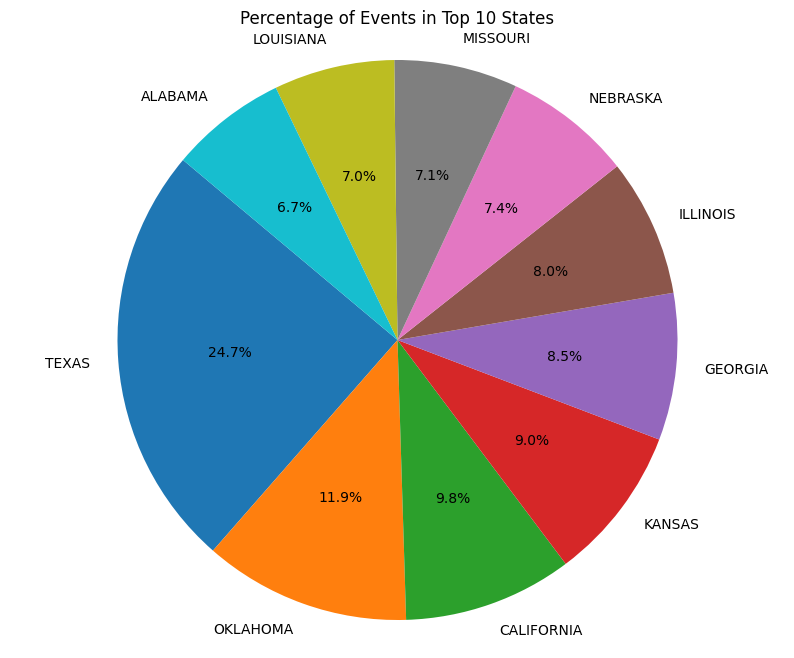

In [0]:
# Calculate total counts per state
state_counts = storm_data.groupBy("STATE").count().orderBy(col("count").desc())

# Find the top 10 states
top_10_states = state_counts.limit(10)

# Calculate the total events for normalization
total_events = state_counts.groupBy().sum("count").collect()[0][0]

# Collect data for top 10 states to calculate their percentage
top_10_states_data = top_10_states.collect()

# Prepare data for the pie chart
states = [row['STATE'] for row in top_10_states_data]
counts = [row['count'] for row in top_10_states_data]
percentages = [(count / total_events) * 100 for count in counts]

# Plotting a pie chart
plt.figure(figsize=(10, 8))
plt.pie(percentages, labels=states, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Events in Top 10 States')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [0]:
from pyspark.sql import functions as F
# Aggregate the total counts of deaths and injuries by state into a single column
total_death_injury_stats = filtered_data.groupBy("STATE").agg(
    (F.sum("DEATHS_DIRECT") + F.sum("DEATHS_INDIRECT") + 
     F.sum("INJURIES_DIRECT") + F.sum("INJURIES_INDIRECT")).alias("Total_Deaths_and_Injuries")
)

# Filter to keep only states with more than 0 total deaths and injuries
filtered_stats = total_death_injury_stats.filter(F.col("Total_Deaths_and_Injuries") > 5)

# Order by the total deaths and injuries in descending order
sorted_total_death_injury_stats = filtered_stats.orderBy(F.col("Total_Deaths_and_Injuries").desc())

# Show the sorted and filtered DataFrame - This prints the DataFrame contents to the console
sorted_total_death_injury_stats.show()


+--------------+-------------------------+
|         STATE|Total_Deaths_and_Injuries|
+--------------+-------------------------+
|         TEXAS|                     1670|
|       ARIZONA|                      181|
|      MISSOURI|                      151|
|      OKLAHOMA|                      127|
|      COLORADO|                       92|
|        NEVADA|                       43|
|       FLORIDA|                       29|
|       ALABAMA|                       29|
|  PENNSYLVANIA|                       26|
|     TENNESSEE|                       26|
|       INDIANA|                       20|
|   MISSISSIPPI|                       17|
|         IDAHO|                       12|
|    CALIFORNIA|                       12|
|      KENTUCKY|                       12|
|NORTH CAROLINA|                       10|
|      ILLINOIS|                        9|
|     LOUISIANA|                        9|
|SOUTH CAROLINA|                        7|
|          OHIO|                        6|
+----------

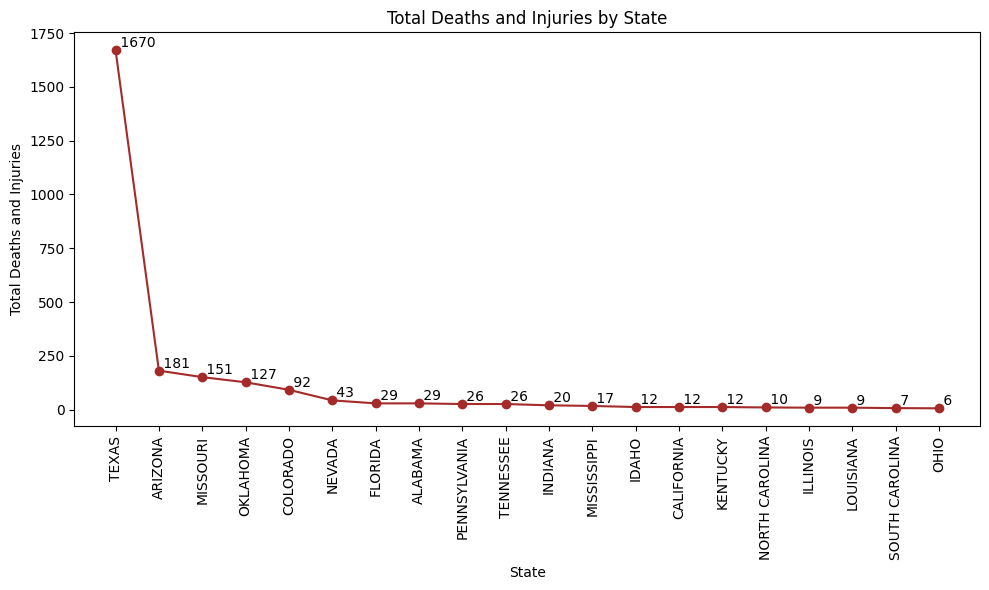

In [0]:
# Collect the data necessary for plotting
plot_data = sorted_total_death_injury_stats.collect()

# Prepare lists for the plot
states = [row['STATE'] for row in plot_data]
totals = [row['Total_Deaths_and_Injuries'] for row in plot_data]

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(states, totals, marker='o', color='brown')  # 'o' for circle markers

# Mark the values on the plot
for i, value in enumerate(totals):
    plt.text(states[i], value, f' {value}', verticalalignment='bottom')

# Set plot title and labels
plt.title('Total Deaths and Injuries by State')
plt.xlabel('State')
plt.ylabel('Total Deaths and Injuries')
plt.xticks(rotation=90)  # Rotate state labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()

In [0]:

# Group by both 'STATE' and 'WFO', then aggregate the total counts of deaths and injuries
total_death_injury_stats = storm_data.groupBy("STATE", "WFO").agg(
    (F.sum("DEATHS_DIRECT") + F.sum("DEATHS_INDIRECT") +
     F.sum("INJURIES_DIRECT") + F.sum("INJURIES_INDIRECT")).alias("Total_Deaths_and_Injuries")
)

# Filter to keep only records with more than 5 total deaths and injuries
significant_impacts = total_death_injury_stats.filter(F.col("Total_Deaths_and_Injuries") > 0)

# Group by 'STATE' and collect all associated 'WFO' into a list
state_wfo_aggregation = significant_impacts.groupBy("STATE").agg(
    F.collect_list("WFO").alias("List_of_WFOs"),
    F.sum("Total_Deaths_and_Injuries").alias("Total_Deaths_and_Injuries")
)

# Order by the total deaths and injuries in descending order for better visibility
ordered_state_wfo_aggregation = state_wfo_aggregation.orderBy(F.col("Total_Deaths_and_Injuries").desc())

# Show the DataFrame with state names, list of WFOs, and the total counts
ordered_state_wfo_aggregation.show(truncate=False)


+-----------+------------------------------------------------------------+-------------------------+
|STATE      |List_of_WFOs                                                |Total_Deaths_and_Injuries|
+-----------+------------------------------------------------------------+-------------------------+
|TEXAS      |[LUB, CRP, BRO, EWX, LCH, SJT, MAF, SHV, EPZ, HGX, FWD, AMA]|1874                     |
|MISSOURI   |[LSX, SGF, EAX, PAH]                                        |221                      |
|ARIZONA    |[FGZ, PSR, VEF, TWC]                                        |207                      |
|TENNESSEE  |[OHX, MEG, MRX]                                             |193                      |
|OKLAHOMA   |[OUN, TSA, SHV]                                             |161                      |
|HAWAII     |[HFO]                                                       |147                      |
|MISSISSIPPI|[JAN, MEG, LIX]                                             |141              

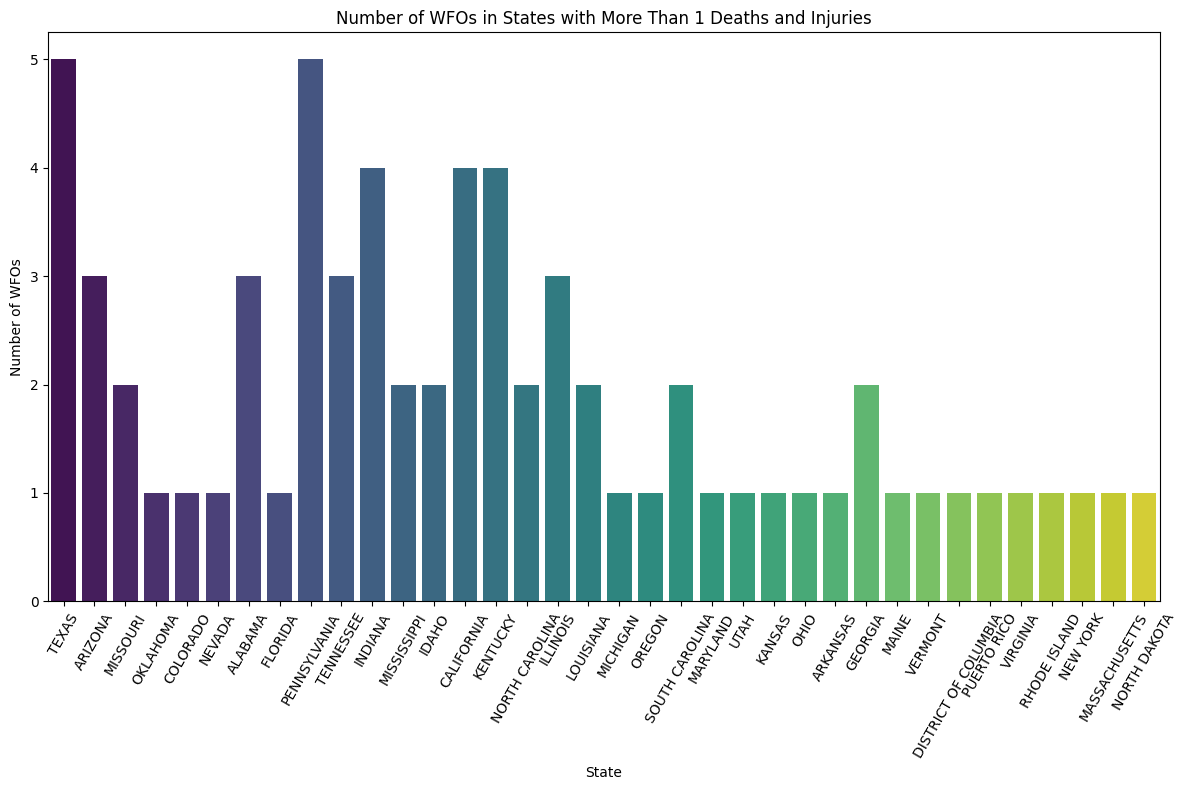

In [0]:
import seaborn as sns
import pandas as pd

# Group by both 'STATE' and 'WFO', then aggregate the total counts of deaths and injuries
total_death_injury_stats = filtered_data.groupBy("STATE", "WFO").agg(
    (F.sum("DEATHS_DIRECT") + F.sum("DEATHS_INDIRECT") +
     F.sum("INJURIES_DIRECT") + F.sum("INJURIES_INDIRECT")).alias("Total_Deaths_and_Injuries")
)

# Filter to keep only records with more than 1 total deaths and injuries
significant_impacts = total_death_injury_stats.filter(F.col("Total_Deaths_and_Injuries") > 1)

# Group by 'STATE' and collect all associated 'WFO' into a list and count the distinct WFOs
state_wfo_aggregation = significant_impacts.groupBy("STATE").agg(
    F.collect_list("WFO").alias("List_of_WFOs"),
    F.countDistinct("WFO").alias("Count_of_WFOs"),
    F.sum("Total_Deaths_and_Injuries").alias("Total_Deaths_and_Injuries")
)

# Order by the total deaths and injuries in descending order for better visibility
ordered_state_wfo_aggregation = state_wfo_aggregation.orderBy(F.col("Total_Deaths_and_Injuries").desc())

# Convert to Pandas DataFrame for visualization
pandas_df = ordered_state_wfo_aggregation.select("STATE", "Count_of_WFOs").toPandas()

# Plotting using seaborn for a more aesthetic look
plt.figure(figsize=(12, 8))
sns.barplot(x='STATE', y='Count_of_WFOs', data=pandas_df, palette='viridis')
plt.title('Number of WFOs in States with More Than 1 Deaths and Injuries')
plt.xlabel('State')
plt.ylabel('Number of WFOs')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


In [0]:
# Group by 'STATE', 'EVENT_TYPE', then aggregate the total counts of deaths and injuries
event_death_injury_stats = storm_data.groupBy("STATE", "EVENT_TYPE").agg(
    (F.sum("DEATHS_DIRECT") + F.sum("DEATHS_INDIRECT") +
     F.sum("INJURIES_DIRECT") + F.sum("INJURIES_INDIRECT")).alias("Total_Deaths_and_Injuries")
)

# Filter to keep only records with more than 0 total deaths and injuries
significant_event_impacts = event_death_injury_stats.filter(F.col("Total_Deaths_and_Injuries") > 0)

# Group by 'STATE' and collect all associated 'EVENT_TYPE' into a list and count the events
state_event_aggregation = significant_event_impacts.groupBy("STATE").agg(
    F.collect_list("EVENT_TYPE").alias("List_of_Events"),
    F.sum("Total_Deaths_and_Injuries").alias("Total_Deaths_and_Injuries"),
    F.count("EVENT_TYPE").alias("Count_of_Events")
)

# Order by the total deaths and injuries in descending order for better visibility
ordered_state_event_aggregation = state_event_aggregation.orderBy(F.col("Total_Deaths_and_Injuries").desc())

# Show the DataFrame with state names, list of events, and the total counts
ordered_state_event_aggregation.show(truncate=False)

+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------+
|STATE      |List_of_Events                                                                                                                                                                                                                      |Total_Deaths_and_Injuries|Count_of_Events|
+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------+
|TEXAS      |[Winter Storm, Winter Weather, Heat, Lightning, High Wind, Tornado, Flash Flood, Excessive Heat, Thunderstorm Wind, Cold/Wind Chill]

+-----------------+-------------+-------------+-------------------------+
|       EVENT_TYPE|Max_Magnitude|Min_Magnitude|Total_Deaths_and_Injuries|
+-----------------+-------------+-------------+-------------------------+
|        High Wind|        134.0|         25.0|                       38|
|   Excessive Heat|         NULL|         NULL|                     1804|
|      Flash Flood|         NULL|         NULL|                       55|
|             Heat|         NULL|         NULL|                      348|
|Thunderstorm Wind|        113.0|          4.0|                      209|
|             Hail|          5.9|         0.25|                       96|
|          Drought|         NULL|         NULL|                        0|
+-----------------+-------------+-------------+-------------------------+



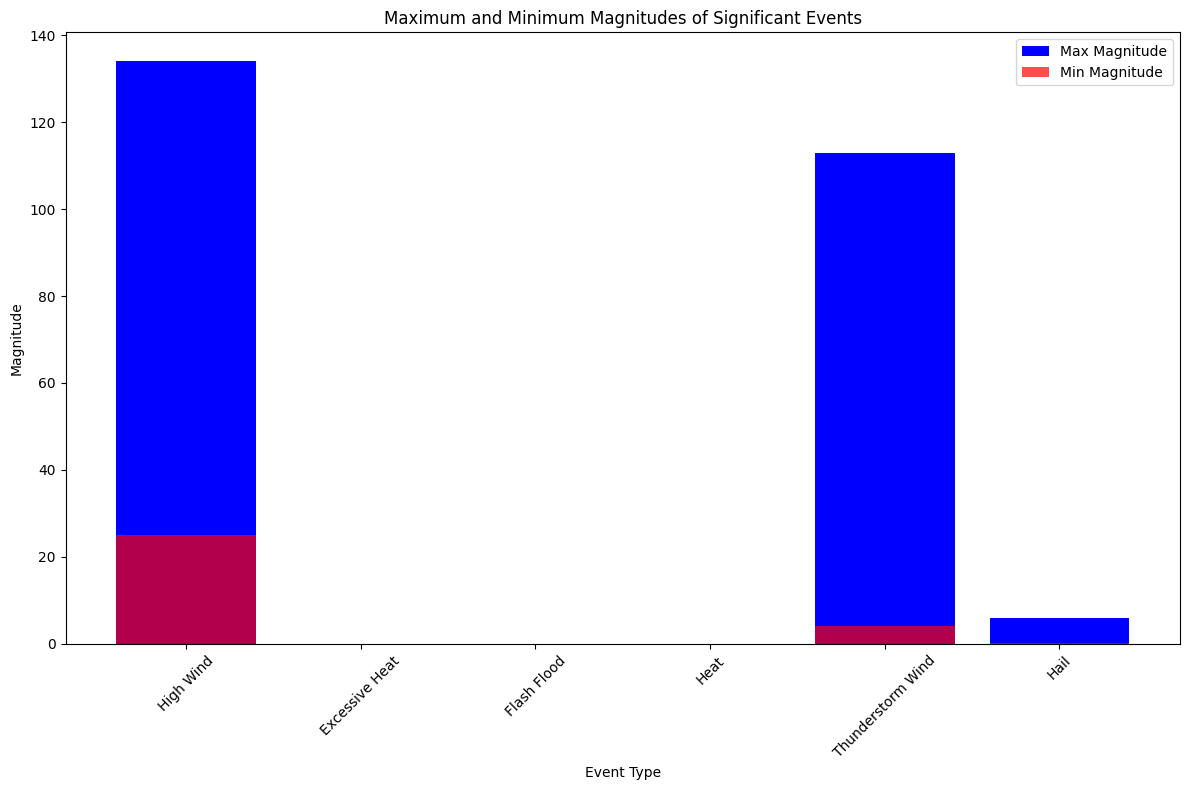

In [0]:
# Group by 'EVENT_TYPE', then aggregate the total counts of deaths and injuries along with max and min magnitudes
event_impact_magnitude_stats = filtered_data.groupBy("EVENT_TYPE").agg(
    F.max("MAGNITUDE").alias("Max_Magnitude"),
    F.min("MAGNITUDE").alias("Min_Magnitude"),
    F.sum(F.col("DEATHS_DIRECT") + F.col("DEATHS_INDIRECT") + 
          F.col("INJURIES_DIRECT") + F.col("INJURIES_INDIRECT")).alias("Total_Deaths_and_Injuries")
)
event_impact_magnitude_stats.show()
# Filter to keep only records with more than 5 total deaths and injuries
significant_event_magnitudes = event_impact_magnitude_stats.filter(F.col("Total_Deaths_and_Injuries") > 0)

# Collect the data for visualization
data_for_plot = significant_event_magnitudes.toPandas()

import matplotlib.pyplot as plt

# Create a plot for the max and min magnitudes of significant events
plt.figure(figsize=(12, 8))
plt.bar(data_for_plot['EVENT_TYPE'], data_for_plot['Max_Magnitude'], color='b', label='Max Magnitude')
plt.bar(data_for_plot['EVENT_TYPE'], data_for_plot['Min_Magnitude'], color='r', alpha=0.7, label='Min Magnitude')
plt.xlabel('Event Type')
plt.ylabel('Magnitude')
plt.title('Maximum and Minimum Magnitudes of Significant Events')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
storm_data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/StormEvents_details_ftp_v1_0_d2023_c20240317.csv", inferSchema=True)

# Calculating the Storm duration

# Define the datetime format 
datetime_format = "dd-MMM-yy HH:mm:ss"

# Converting string datetime to timestamp data type
storm_data = storm_data.withColumn('BEGIN_DATE_TIME', to_timestamp('BEGIN_DATE_TIME', datetime_format))
storm_data = storm_data.withColumn('END_DATE_TIME', to_timestamp('END_DATE_TIME', datetime_format))

# Calculating the duration in hours
storm_data = storm_data.withColumn('STORM_DUR_HR', (col('END_DATE_TIME').cast("long") - col('BEGIN_DATE_TIME').cast("long")) / 3600)

# Dropping the original datetime columns
storm_data = storm_data.drop('BEGIN_DATE_TIME', 'END_DATE_TIME')

In [0]:
# Filtering the most top two common event types based on the number of occurrences. 
event_types = ['Thunderstorm Wind', 'Hail']
storm_data = storm_data[storm_data.EVENT_TYPE.isin(event_types)]

In [0]:
# Choosing the relevant columns
relevant_columns = [
    "STATE", "MONTH_NAME", "WFO", "INJURIES_DIRECT","EVENT_TYPE","CZ_NAME","BEGIN_AZIMUTH","END_AZIMUTH",
    "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", "DAMAGE_PROPERTY","BEGIN_LAT","BEGIN_LON","END_LAT","END_LON",
    "DAMAGE_CROPS", "SOURCE","STORM_DUR_HR","MAGNITUDE"
]
storm_data = storm_data.select(*relevant_columns)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Dropping records with null values
storm_data = storm_data.dropna(subset=["DAMAGE_PROPERTY", "DAMAGE_CROPS","BEGIN_LAT","BEGIN_LON","END_LAT","END_LON","MAGNITUDE"])

def convert_damage(value):
    # Checking if the value is already a float 
    try:
        return float(value)
    except ValueError:
        # If not, then process as a string
        if value.endswith('K'):
            return float(value[:-1]) * 1000
        elif value.endswith('M'):
            return float(value[:-1]) * 1000000
        else:
            # Handle cases where conversion isn't clear
            return None
    
    # Converting the Python function to a UDF
convert_damage_udf = udf(convert_damage, FloatType())

# Applying the UDF to the DataFrame for both damage columns
storm_data = storm_data.withColumn("DAMAGE_PROPERTY", convert_damage_udf("DAMAGE_PROPERTY"))
storm_data = storm_data.withColumn("DAMAGE_CROPS", convert_damage_udf("DAMAGE_CROPS"))

In [0]:
# Splitting the data into training and testing sets
trainDF, testDF = storm_data.randomSplit([0.8, 0.2], seed=10)
print(trainDF.cache().count()) 
print(testDF.count())

17981
4506


In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
categoricalCols = ["STATE", "MONTH_NAME", "SOURCE", "WFO","CZ_NAME","BEGIN_AZIMUTH","END_AZIMUTH"]
 
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols],handleInvalid="keep") 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 
 
# Convert it to a numeric value using StringIndexer.
labelToIndex = StringIndexer(inputCol="EVENT_TYPE", outputCol="label")

In [0]:
from pyspark.ml.feature import VectorAssembler
 
# This includes both the numeric columns and the one-hot encoded binary vector columns in the dataset.
numericCols = ["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", 
               "DAMAGE_PROPERTY", "DAMAGE_CROPS", "BEGIN_LAT", "BEGIN_LON", 
               "END_LAT", "END_LON", "STORM_DUR_HR"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [0]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)

In [0]:
from pyspark.ml import Pipeline
 
# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr])
 
# Define the pipeline model.
pipelineModel = pipeline.fit(trainDF)
 
# Apply the pipeline model to the test dataset.
predDF = pipelineModel.transform(testDF)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
display(predDF.select("features", "label", "prediction", "probability")) 

features label prediction probability Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 70, 116, 219, 1643, 1661, 1669, 1670, 1671, 1672, 1673), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.37, -86.26, 32.37, -86.26, 0.016666666666666666)) 1.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7362105939327683, 0.26378940606723167)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 64, 105, 220, 1632, 1648, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.93, -87.79, 34.93, -87.79)) 1.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7276049217522282, 0.27239507824777176)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 64, 105, 354, 1634, 1650, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000.0, 34.24, -86.88, 34.24, -86.88)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7403932995578614, 0.2596067004421386)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 65, 105, 216, 1642, 1656, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2000.0, 34.74, -85.94, 34.74, -85.94)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7919458354061804, 0.20805416459381965)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 65, 105, 216, 1644, 1659, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2000.0, 34.67, -86.26, 34.67, -86.26)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7969197852663922, 0.20308021473360782)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 66, 105, 220, 1637, 1653, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2000.0, 34.86, -87.34, 34.86, -87.34)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7339832247331489, 0.2660167752668511)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 64, 100, 255, 1645, 1660, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5000.0, 31.58, -85.98, 31.58, -85.98)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.734238033935368, 0.265761966064632)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 65, 100, 379, 1641, 1655, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.59, -85.54, 31.59, -85.54)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8158342322134857, 0.18416576778651428)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 65, 100, 379, 1632, 1648, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.56, -85.77, 31.56, -85.77)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8073117881211985, 0.19268821187880147)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 59, 65, 100, 379, 1632, 1648, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.6, -85.53, 31.6, -85.53)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8077490734794331, 0.19225092652056686)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 53, 65, 105, 218, 1640, 1658, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.47, -87.38, 34.47, -87.38)) 1.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7848184734284634, 0.21518152657153655)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 53, 65, 105, 231, 1637, 1653, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 200.0, 34.5742, -87.526, 34.5742, -87.526)) 0.0 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.7976883128002765, 0.20231168719972348)) Map(vectorType -> sparse, length -> 1674, indices -> List(2, 53, 65, 105, 231, 1632, 1648, 1667, 1669, 1670, 1671, 1672), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000.0, 34.7506, -87.6411, 34.7506, -87.6411)) 0.0 0.0 Map(vectorType -> dense, 

In [0]:
display(pipelineModel.stages[-1], predDF.drop("prediction", "rawPrediction", "probability"), "ROC")

False Positive Rate True Positive Rate Threshold 0.0 0.0 0.639374317220683 0.0 0.027777777777777776 0.639374317220683 0.015151515151515152 0.027777777777777776 0.6234879988833976 0.015151515151515152 0.05555555555555555 0.6085952797991401 0.015151515151515152 0.08333333333333333 0.5710041438709279 0.030303030303030304 0.08333333333333333 0.5636695179137022 0.030303030303030304 0.1111111111111111 0.558156209243772 0.030303030303030304 0.1388888888888889 0.5552712220872418 0.030303030303030304 0.16666666666666666 0.5507379047944315 0.030303030303030304 0.19444444444444445 0.5407597945159954 0.030303030303030304 0.2222222222222222 0.5383136279934169 0.030303030303030304 0.25 0.5367494440956916 0.030303030303030304 0.2777777777777778 0.5261363424794463 0.030303030303030304 0.3055555555555556 0.5054800952042147 0.030303030303030304 0.3333333333333333 0.4957340267500684 0.030303030303030304 0.3611111111111111 0.4812354363859698 0.030303030303030304 0.3888888888888889 0.47598897887766956 0.030303030303030304 0.4166666666666667 0.4731149373087682 0.030303030303030304 0.4444444444444444 0.473070829610309 0.030303030303030304 0.4722222222222222 0.4701958540481068 0.030303030303030304 0.5 0.4642661725892352 0.045454545454545456 0.5 0.45265059401056085 0.06060606060606061 0.5 0.4509172277087893 0.06060606060606061 0.5277777777777778 0.4294365781695917 0.06060606060606061 0.5555555555555556 0.4266844366770176 0.07575757575757576 0.5555555555555556 0.4263793231981131 0.07575757575757576 0.5833333333333334 0.42607556904966426 0.09090909090909091 0.5833333333333334 0.42095006214513153 0.10606060606060606 0.5833333333333334 0.4067336243840365 0.12121212121212122 0.5833333333333334 0.4064989838126898 0.12121212121212122 0.6111111111111112 0.4043684916651492 0.12121212121212122 0.6388888888888888 0.4040094470650817 0.12121212121212122 0.6666666666666666 0.40390497516331736 0.12121212121212122 0.6944444444444444 0.4012608548529677 0.13636363636363635 0.6944444444444444 0.39550587882150645 0.13636363636363635 0.7222222222222222 0.3876003116824214 0.13636363636363635 0.75 0.38287569771021446 0.15151515151515152 0.75 0.37516613106786967 0.15151515151515152 0.7777777777777778 0.36932874150961337 0.16666666666666666 0.7777777777777778 0.36458233953239194 0.18181818181818182 0.7777777777777778 0.3627877297824351 0.18181818181818182 0.8055555555555556 0.3625732314288178 0.19696969696969696 0.8055555555555556 0.35878820423123514 0.19696969696969696 0.8333333333333334 0.3580319479292634 0.21212121212121213 0.8333333333333334 0.347156218168322 0.22727272727272727 0.8333333333333334 0.3416146506507405 0.24242424242424243 0.8333333333333334 0.341027988624103 0.25757575757575757 0.8333333333333334 0.3383539314309435 0.25757575757575757 0.8611111111111112 0.3347013885797422 0.2727272727272727 0.8611111111111112 0.33466132201212273 0.2727272727272727 0.8888888888888888 0.3302982362703366 0.2878787878787879 0.8888888888888888 0.3236546771383292 0.30303030303030304 0.8888888888888888 0.3203703226420386 0.3181818181818182 0.8888888888888888 0.31368208817925325 0.3333333333333333 0.8888888888888888 0.3133600856329365 0.3484848484848485 0.8888888888888888 0.3129778609549241 0.36363636363636365 0.8888888888888888 0.309997074445843 0.3787878787878788 0.8888888888888888 0.3099227527653666 0.3939393939393939 0.8888888888888888 0.308873787379492 0.4090909090909091 0.8888888888888888 0.308455090790848 0.4090909090909091 0.9166666666666666 0.307346596263386 0.42424242424242425 0.9166666666666666 0.305565718498247 0.4393939393939394 0.9166666666666666 0.3008099621040806 0.45454545454545453 0.9166666666666666 0.29979054386257065 0.4696969696969697 0.9166666666666666 0.2986846167882551 0.48484848484848486 0.9166666666666666 0.29824697500425934 0.5 0.9166666666666666 0.2947716657219749 0.5151515151515151 0.9166666666666666 0.2905482250793622 0.5303030303030303 0.9166666666666666 0.2879106284828542 0.5454545454545454 0.9166666666666666 0.28098643602133244 0.5606060606060606 0.9

In [0]:
# Evaluating the models
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
 
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")
 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

f1Evaluator = MulticlassClassificationEvaluator(metricName="f1")
print(f"F1 Score: {f1Evaluator.evaluate(predDF)}")

Area under ROC curve: 0.8755353785841585
Accuracy: 0.7514425210830005
F1 Score: 0.7103445050096353


In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
 
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

The Step Below takes 25 Mins to run

In [0]:
# Create a 3-fold CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=bcEvaluator, numFolds=3, parallelism = 4)
 
# Run cross validations. This step takes approxiamtely 25 minutes and returns the best model found from the cross validation.
cvModel = cv.fit(trainDF)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
# Use the model identified by the cross-validation to make predictions on the test dataset
cvPredDF = cvModel.transform(testDF)
 
# Evaluate the model's performance based on area under the ROC curve and accuracy 
print(f"Area under ROC curve: {bcEvaluator.evaluate(cvPredDF)}")
print(f"Accuracy: {mcEvaluator.evaluate(cvPredDF)}")
print(f"F1 Score: {f1Evaluator.evaluate(cvPredDF)}")

Area under ROC curve: 0.8943109049816362
Accuracy: 0.8164669329782512
F1 Score: 0.8137070977919385


In [0]:
import pandas as pd

#FEATURE IMPORTANCE
lrModel = pipelineModel.stages[-1]

coefficients = lrModel.coefficients

feature_names = vecAssembler.getInputCols()

coeffs_df = pd.DataFrame(list(zip(feature_names, coefficients)), columns=["Feature", "Coefficient"])

coeffs_df = coeffs_df.reindex(coeffs_df['Coefficient'].abs().sort_values(ascending=False).index)

print(coeffs_df)

              Feature  Coefficient
17       STORM_DUR_HR     0.254185
0            STATEOHE     0.156768
6      END_AZIMUTHOHE    -0.143747
9       DEATHS_DIRECT    -0.125799
7     INJURIES_DIRECT    -0.116612
2           SOURCEOHE    -0.109698
12       DAMAGE_CROPS    -0.100732
16            END_LON    -0.097522
8   INJURIES_INDIRECT    -0.094483
14          BEGIN_LON    -0.088465
15            END_LAT    -0.081693
11    DAMAGE_PROPERTY    -0.077364
10    DEATHS_INDIRECT     0.072315
3              WFOOHE     0.043113
13          BEGIN_LAT    -0.039076
4          CZ_NAMEOHE     0.028295
5    BEGIN_AZIMUTHOHE    -0.022860
1       MONTH_NAMEOHE     0.013471


In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)

In [0]:
# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, rf])
 
# Define the pipeline model.
pipelineModel = pipeline.fit(trainDF)
 
# Apply the pipeline model to the test dataset.
predDF = pipelineModel.transform(testDF)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve Random Forest Model: {bcEvaluator.evaluate(predDF)}")
 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy for the Random Forest Model: {mcEvaluator.evaluate(predDF)}")

f1Evaluator = MulticlassClassificationEvaluator(metricName="f1")
print(f"F1 Score For the random Forest model: {f1Evaluator.evaluate(predDF)}")

Area under ROC curve Random Forest Model: 0.8255387355997112
Accuracy for the Random Forest Model: 0.6875277407900577
F1 Score For the random Forest model: 0.5963478500969289


In [0]:
storm_data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/StormEvents_details_ftp_v1_0_d2023_c20240317.csv", inferSchema=True)

# Defining the datetime format 
datetime_format = "dd-MMM-yy HH:mm:ss"

# Converting string datetime to timestamp data type
storm_data = storm_data.withColumn('BEGIN_DATE_TIME', to_timestamp('BEGIN_DATE_TIME', datetime_format))
storm_data = storm_data.withColumn('END_DATE_TIME', to_timestamp('END_DATE_TIME', datetime_format))

# Calculating the duration in hours
storm_data = storm_data.withColumn('STORM_DUR_HR', (col('END_DATE_TIME').cast("long") - col('BEGIN_DATE_TIME').cast("long")) / 3600)

# Dropping the original datetime columns
storm_data = storm_data.drop('BEGIN_DATE_TIME', 'END_DATE_TIME')

# Filtering the event types which is calculated on the same magnitude scale 
storm_data = storm_data.filter(storm_data.MAGNITUDE_TYPE == 'EG')

In [0]:
# Choosing the relevant columns
relevant_columns = [
    "STATE", "MONTH_NAME", "WFO", "INJURIES_DIRECT","EVENT_TYPE","CZ_NAME","BEGIN_AZIMUTH","END_AZIMUTH",
    "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", "DAMAGE_PROPERTY","BEGIN_LAT","BEGIN_LON","END_LAT","END_LON",
    "DAMAGE_CROPS", "SOURCE","STORM_DUR_HR","MAGNITUDE"
]
storm_data = storm_data.select(*relevant_columns)

In [0]:
# Dropping records with null values
storm_data = storm_data.dropna(subset=["DAMAGE_PROPERTY", "DAMAGE_CROPS","BEGIN_LAT","BEGIN_LON","END_LAT","END_LON","MAGNITUDE"])

In [0]:
# Function to convert the damage columns from String to float
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def convert_damage(value):
    # Checking if the value is already a float
    try:
        return float(value)
    except ValueError:
        # If not, then process as a string
        if value.endswith('K'):
            return float(value[:-1]) * 1000
        elif value.endswith('M'):
            return float(value[:-1]) * 1000000
        else:
            # Handle cases where conversion isn't clear
            return None
    
    # Converting the Python function to a UDF
convert_damage_udf = udf(convert_damage, FloatType())

# Apply the function to the DataFrame to convert both damage columns
storm_data = storm_data.withColumn("DAMAGE_PROPERTY", convert_damage_udf("DAMAGE_PROPERTY"))
storm_data = storm_data.withColumn("DAMAGE_CROPS", convert_damage_udf("DAMAGE_CROPS"))

In [0]:
# Splitting the data into training and testing sets
trainDF, testDF = storm_data.randomSplit([0.8, 0.2], seed=42)
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())

10263
2446


In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
categoricalCols = ["STATE", "MONTH_NAME", "SOURCE", "WFO","CZ_NAME","BEGIN_AZIMUTH","END_AZIMUTH","EVENT_TYPE"]
 
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols],handleInvalid="keep") 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 

In [0]:
from pyspark.ml.feature import VectorAssembler
 
# This includes both the numeric columns and the one-hot encoded binary vector columns in the dataset.
numericCols = ["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", 
               "DAMAGE_PROPERTY", "DAMAGE_CROPS", "BEGIN_LAT", "BEGIN_LON", 
               "END_LAT", "END_LON", "STORM_DUR_HR"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [0]:
from pyspark.ml.regression import LinearRegression

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="MAGNITUDE")

In [0]:
from pyspark.ml import Pipeline
 
# Defining the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder, vecAssembler, lr])
 
# Defining the pipeline model.
pipelineModel = pipeline.fit(trainDF)
 
# Applying the pipeline model to the test dataset.
predDF = pipelineModel.transform(testDF)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluating the model
evaluator_rmse = RegressionEvaluator(labelCol="MAGNITUDE", predictionCol="prediction", metricName="rmse")
evaluator_R2 = RegressionEvaluator(labelCol="MAGNITUDE", predictionCol="prediction", metricName="r2")

# RMSE for Linear Regression
rmse_lr = evaluator_rmse.evaluate(predDF)
print(f"Root Mean Squared Error (RMSE) on test data for Linear Regression = {rmse_lr}")

# R-squared for Linear Regression
R2_lr = evaluator_R2.evaluate(predDF)
print(f"R-squared on test data for Linear Regression = {R2_lr}")

Root Mean Squared Error (RMSE) on test data for Linear Regression = 4.9821081400734
R-squared on test data for Linear Regression = 0.505786019853931


In [0]:
from pyspark.ml.regression import GBTRegressor

# Gradient boosted tree regressor model
gbt = GBTRegressor(featuresCol="features", labelCol="MAGNITUDE", maxIter=10)

# Defining the pipeline
pipeline_gbt = Pipeline(stages=[stringIndexer, encoder, vecAssembler, gbt])

# Fitting the pipeline on the training data
pipelineModel_gbt = pipeline_gbt.fit(trainDF)

# Making predictions on the test data
predDF_gbt = pipelineModel_gbt.transform(testDF)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
# Evaluating the Gradient boosted model
rmse_gbt = evaluator_rmse.evaluate(predDF_gbt)
print(f"Root Mean Squared Error (RMSE) on test data for GBT = {rmse_gbt}")

# R-squared for Gradient-Boosted Tree
R2_gbt = evaluator_R2.evaluate(predDF_gbt)
print(f"R-squared on test data for GBT = {R2_gbt}")

Root Mean Squared Error (RMSE) on test data for GBT = 4.97717953796602
R-squared on test data for GBT = 0.5067633488011486


In [0]:
import pandas as pd
# Feature importances 

# Coefficients for Linear Regression
lr_model = pipelineModel.stages[-1]
lr_coefficients = lr_model.coefficients
features_df = pd.DataFrame(list(zip(vecAssembler.getInputCols(), lr_coefficients)), columns=["Feature", "Coefficient"])
features_df = features_df.sort_values(by="Coefficient", ascending=False)
print("Coefficients for Linear Regression:")
print(features_df)

Coefficients for Linear Regression:
              Feature  Coefficient
16            END_LAT     4.082885
14          BEGIN_LAT     2.078597
5    BEGIN_AZIMUTHOHE     2.004412
11    DEATHS_INDIRECT     1.416560
1       MONTH_NAMEOHE     1.371450
15          BEGIN_LON     1.109963
4          CZ_NAMEOHE     0.754269
9   INJURIES_INDIRECT     0.614645
17            END_LON     0.603260
8     INJURIES_DIRECT     0.602939
18       STORM_DUR_HR    -0.248576
2           SOURCEOHE    -0.554597
3              WFOOHE    -0.961059
13       DAMAGE_CROPS    -0.968246
0            STATEOHE    -1.088993
7       EVENT_TYPEOHE    -1.124963
12    DAMAGE_PROPERTY    -1.489088
10      DEATHS_DIRECT    -3.648417
6      END_AZIMUTHOHE    -5.202672


In [0]:
# For Gradient Boosted Trees
gbt_feature_importances = pipelineModel_gbt.stages[-1].featureImportances
gbt_features_df = pd.DataFrame(list(zip(vecAssembler.getInputCols(), gbt_feature_importances)), columns=["Feature", "Importance"])
gbt_features_df = gbt_features_df.sort_values(by="Importance", ascending=False).head(5)
print("Top features for Gradient Boosted Trees:")
print(gbt_features_df)

Top features for Gradient Boosted Trees:
             Feature  Importance
1      MONTH_NAMEOHE    0.038971
6     END_AZIMUTHOHE    0.009025
5   BEGIN_AZIMUTHOHE    0.005940
16           END_LAT    0.004620
8    INJURIES_DIRECT    0.002171


References:
[1] Dr. Liao’s Code Examples & Tutorials: Blackboard/AIT614 Lab6 Spark ML.pdf